# **239AS Computational Imaging Final Project**
By: Chris Chien, Daniel Ahn, Hersh Joshi, Patrick Xu, Ran Gong

1. Generating guassian blur kernal: http://dev.theomader.com/gaussian-kernel-calculator/
1. Convolving image in fourier domain: https://stackoverflow.com/questions/54877892/convolving-image-with-kernel-in-fourier-domain

# Mounting Google Drive

**Mounting Google Drive to See Dataset File.** Mounting the files via Google Drive will save us the pain of uploading a gigabyte worth of data every time we restart our runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/My\ Drive/UCLA/209AS Artificial Intelligence on Chips/

In [ ]:
import numpy as np
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Lambda 
from keras.layers.normalization import BatchNormalization
from keras import layers
from keras import models
from keras import activations
from keras import backend as K
from keras import losses
import cv2
from google.colab.patches import cv2_imshow
import scipy as sp
from scipy import signal
from numpy import linalg as LA
import matplotlib.pyplot as plt


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


#Parameters

In [ ]:
#parameters
row = 300
col = 300
ch =3
mean = 0
var = 25
sigma = 7
gaussian_kernel_sigma1 = np.array([[1 / 256, 4 / 256,  6 / 256,  4 / 256, 1 / 256],
                                   [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
                                   [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
                                   [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
                                   [1 / 256, 4 / 256,  6 / 256,  4 / 256, 1 / 256]]).astype(np.float32)

gaussian_kernel_sigma10_2 = np.array([[0.039236, 0.039806, 0.039998, 0.039806, 0.039236],
                                      [0.039806, 0.040383, 0.040578, 0.040383, 0.039806],
                                      [0.039998, 0.040578, 0.040773, 0.040578, 0.039998],
                                      [0.039806, 0.040383, 0.040578, 0.040383, 0.039806],
                                      [0.039236, 0.039806, 0.039998, 0.039806, 0.039236]]).astype(np.float32)

identity_kernel = np.array([[0,0,0],[0,1,0],[0,0,0]]).astype(np.float32)

motion_kernel = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0008, 0.0017, 0.0025, 0.0033, 0.0042, 0.0050, 0.0058, 0.0067, 0.0075, 0.0083],
                          [0.0393, 0.0401, 0.0410, 0.0418, 0.0426, 0.0435, 0.0443, 0.0451, 0.0460, 0.0468, 0.0476, 0.0468, 0.0460, 0.0451, 0.0443, 0.0435, 0.0426, 0.0418, 0.0410, 0.0401, 0.0393],
                          [ 0.0083, 0.0075, 0.0067, 0.0058, 0.0050, 0.0042, 0.0033, 0.0025, 0.0017, 0.0008, 0.0000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]).astype(np.float32)
#[0,0,0,0,0],
motion_kernal1 = np.array([[0.123, 0.354, 0.0035, 0.0035, 0.007],
                           [0.193, .1965, .2, .1965, .193], 
                           [.007, .0035, 0.523, 0.235, 0.344]]).astype(np.float32)

disk_kernel= np.array([[0,0,0,0,0.0000,0.0013,0.0027,0.0032,0.0027,0.0013,0.0000,0,0,0,0],
                       [0,0,0,0.0016,0.0053,0.0065,0.0065,0.0065,0.0065,0.0065,0.0053,0.0016,0,0,0],
                       [0,0,0.0026,0.0064,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0064,.0026,0,0],
                       [0,0.0016,0.0064,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0064,.0016,0],
                       [0.0000,0.0053,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0065,.0053,0],
                       [0.0013,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0065,.0065,.0013],
                       [0.0027,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0065,.0065,.0027],
                       [0.0032,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0065,.0065,.0032],
                       [0.0027,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0065,.0065,.0027],
                       [0.0013,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0064,.0053,.0013],
                       [0.0000,0.0053,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,.0065,.0053,0],
                       [0,0.0016,0.0064,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0064,.0016,0,0,],
                       [0,0,0.0026,0.0064,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0064,.0026,0,0],
                       [0,0,0,0.0016,0.0053,0.0065,0.0065,0.0065,0.0065,0.0065,0.0053,0.0016,0,0,0],
                       [0,0,0,0,0.0000,0.0013,.0027,0.0032,0.0027,0.0013,0.0000,0,0,0,0]]).astype(np.float32)             


gaussian_kernel_sigma3 = np.array([[0.000082,0.000167,0.000306,0.000502,0.000738,0.000971,0.001146,0.001211,0.001146,0.000971,0.000738,0.000502,0.000306,0.000167,0.000082],
                                  [0.000167,0.000341,0.000625,0.001026,0.001509,0.001987,0.002344,0.002476,0.002344,0.001987,0.001509,0.001026,0.000625,0.000341,0.000167],
                                  [0.000306,0.000625,0.001146,0.001881,0.002765,0.003641,0.004294,0.004537,0.004294,0.003641,0.002765,0.001881,0.001146,0.000625,0.000306],
                                  [0.000502,0.001026,0.001881,0.003086,0.004537,0.005975,0.007047,0.007446,0.007047,0.005975,0.004537,0.003086,0.001881,0.001026,0.000502],
                                  [0.000738,0.001509,0.002765,0.004537,0.00667,0.008783,0.01036,0.010946,0.01036,0.008783,0.00667,0.004537,0.002765,0.001509,0.000738],
                                  [0.000971,0.001987,0.003641,0.005975,0.008783,0.011566,0.013643,0.014414,0.013643,0.011566,0.008783,0.005975,0.003641,0.001987,0.000971],
                                  [0.001146,0.002344,0.004294,0.007047,0.01036,0.013643,0.016092,0.017002,0.016092,0.013643,0.01036,0.007047,0.004294,0.002344,0.001146],
                                  [0.001211,0.002476,0.004537,0.007446,0.010946,0.014414,0.017002,0.017965,0.017002,0.014414,0.010946,0.007446,0.004537,0.002476,0.001211],
                                  [0.001146,0.002344,0.004294,0.007047,0.01036,0.013643,0.016092,0.017002,0.016092,0.013643,0.01036,0.007047,0.004294,0.002344,0.001146],
                                  [0.000971,0.001987,0.003641,0.005975,0.008783,0.011566,0.013643,0.014414,0.013643,0.011566,0.008783,0.005975,0.003641,0.001987,0.000971],
                                  [0.000738,0.001509,0.002765,0.004537,0.00667,0.008783,0.01036,0.010946,0.01036,0.008783,0.00667,0.004537,0.002765,0.001509,0.000738],
                                  [0.000502,0.001026,0.001881,0.003086,0.004537,0.005975,0.007047,0.007446,0.007047,0.005975,0.004537,0.003086,0.001881,0.001026,0.000502],
                                  [0.000306,0.000625,0.001146,0.001881,0.002765,0.003641,0.004294,0.004537,0.004294,0.003641,0.002765,0.001881,0.001146,0.000625,0.000306],
                                  [0.000167,0.000341,0.000625,0.001026,0.001509,0.001987,0.002344,0.002476,0.002344,0.001987,0.001509,0.001026,0.000625,0.000341,0.000167],[0.000082,0.000167,0.000306,0.000502,0.000738,0.000971,0.001146,0.001211,0.001146,0.000971,0.000738,0.000502,0.000306,0.000167,	0.000082]]).astype(np.float32)

fog_kernel = np.array([[177, 184, 191, 196, 201, 201, 200, 193, 186, 178],
       [180, 186, 193, 201, 206, 209, 206, 198, 189, 180],
       [182, 189, 197, 204, 212, 216, 211, 202, 191, 182],
       [182, 190, 198, 207, 218, 222, 216, 205, 193, 184],
       [184, 191, 199, 209, 222, 229, 221, 206, 196, 184],
       [184, 191, 199, 209, 222, 229, 221, 208, 195, 185],
       [184, 191, 198, 207, 218, 225, 217, 205, 194, 184],
       [183, 190, 197, 204, 213, 217, 211, 202, 192, 184],
       [182, 188, 194, 201, 206, 208, 204, 197, 190, 182],
       [181, 187, 192, 197, 201, 203, 199, 194, 187, 180]], dtype=np.float32)
fog_kernel = fog_kernel/np.sum(fog_kernel)

#Loading the Data


In [ ]:
def LoadData(directory, nametype):
  Originalimages = []
  noisy1Images = []
  noisy10Images = []
  purenoiseImages = []
  motionImages = []
  diskImages = []
  
  for i in range(300):
    name = nametype + str(i+1) + '.jpg'
    for filename in os.listdir(directory):

      if name in filename:
        img = cv2.imread(os.path.join(directory,filename))

        if img is not None:          
          img = cv2.resize(img, (col, row), interpolation = cv2.INTER_AREA)
          img0, img1, img2, img4, img5 =np.copy(img), np.copy(img), np.copy(img), np.copy(img), np.copy(img)
          Originalimages.append(img0)

          #sigma = 10 gaussian blur
          for i in range(3):
            img1[:,:,i] = signal.convolve2d(img1[:,:,i],gaussian_kernel_sigma10_2, boundary='symm', mode='same')
          gauss = np.random.normal(mean,sigma,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          noisy = img1 + gauss
          noisy10Images.append(noisy)

          # #sigma = 1 blur
          for i in range(3):
            img2[:,:,i] = signal.convolve2d(img2[:,:,i],gaussian_kernel_sigma1, boundary='symm', mode='same')
          gauss = np.random.normal(mean,sigma,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          noisy = img2 + gauss
          noisy1Images.append(noisy)

          #motion
          for i in range(3):
            img4[:,:,i] = signal.convolve2d(img4[:,:,i],motion_kernel, boundary='symm', mode='same')
          gauss = np.random.normal(mean,sigma,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          noisy = img4 + gauss
          motionImages.append(noisy)

          #disk blur, using motion for now as placeholder
          for i in range(3):
            img5[:,:,i] = signal.convolve2d(img5[:,:,i],disk_kernel, boundary='symm', mode='same')
          gauss = np.random.normal(mean,sigma,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          noisy = img5 + gauss
          diskImages.append(noisy)
          

  return Originalimages, noisy10Images, noisy1Images, motionImages, diskImages

In [ ]:
def LoadRefData(directory, nametype):
  Originalimages = []
  purenoiseImages = []

  for i in range(200):
    name = nametype + str(i+1) + '.jpg'
    for filename in os.listdir(directory):
      if name in filename:
        img = cv2.imread(os.path.join(directory,filename))

        if img is not None:
          img = cv2.resize(img, (col, row), interpolation = cv2.INTER_AREA)
          img0 = np.copy(img)
          Originalimages.append(img)

          #de noise has sigma = 25
          gauss = np.random.normal(mean,25,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          pnoise = img0 + gauss
          purenoiseImages.append(pnoise)

  return Originalimages, purenoiseImages

## Training dataset

In [ ]:
#Loading original images
imgDir = %pwd
trainrefDir = os.path.join(imgDir, 'train truth for tapered train')
print (trainrefDir)

orgimages, purenoise= LoadRefData(trainrefDir, 'B')
orgimages = np.array(orgimages)
purenoise = np.array(purenoise)

/content/gdrive/My Drive/239 Computational Imaging Project/BSR/BSDS500/data/images/train truth for tapered train


1. Gaussian noise with sigma= 25       2.The Original Image


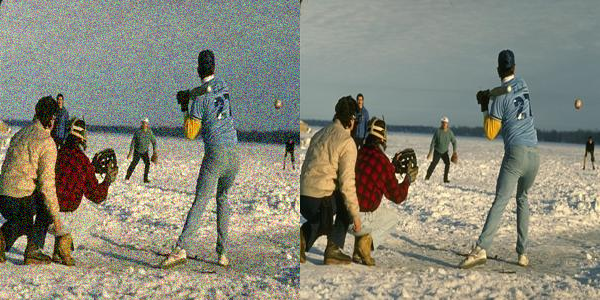

In [ ]:
number = 40

print ( '1. Gaussian noise with sigma= 25       2.The Original Image')
numpy_horizontal = np.hstack((purenoise[number], orgimages[number]))
cv2_imshow(numpy_horizontal)

In [ ]:
#Loading tapered images
imgDir = %pwd
trainDir = os.path.join(imgDir, 'tapered train')
# trainDir = os.path.join(imgDir, 'train truth for tapered train')
print (trainDir)

taped_ref, gnoisy10, gnoisy1, motion, disk = LoadData(trainDir, 'A')
# taped_ref, gnoisy10, gnoisy1, motion, disk = LoadData(trainDir, 'B')
taped_ref = np.array(taped_ref)
gnoisy1 = np.array(gnoisy1)
gnoisy10 = np.array(gnoisy10)
motion = np.array(motion)
disk = np.array(disk)

/content/gdrive/My Drive/239 Computational Imaging Project/BSR/BSDS500/data/images/tapered train


In [ ]:
number = 41
number_1 =48

print ( '1. Gaussian noise, sigma= 25           2.The Original Image                   3.Gaussian blur, sigma= 1               and 4. Gaussian blur sigma= 10.2 ') 
numpy_horizontal = np.hstack((purenoise[number], orgimages[number]))
numpy_horizontal1 = np.hstack((gnoisy1[number], gnoisy10[number]))
numpy_horizontal = np.hstack((numpy_horizontal,numpy_horizontal1))
cv2_imshow(numpy_horizontal)

print ( '5. Disk Blur                           6.Motion Blur                          7. Tapered Images                       and 2. The Original Images') 
numpy_horizontal = np.hstack((disk[number_1], motion[number_1]))
numpy_horizontal1 = np.hstack((taped_ref[number_1], orgimages[number_1]))
numpy_horizontal = np.hstack((numpy_horizontal,numpy_horizontal1))
cv2_imshow(numpy_horizontal)

1. Gaussian noise, sigma= 25           2.The Original Image                   3.Gaussian blur, sigma= 1               and 4. Gaussian blur sigma= 10.2 


IndexError: ignored

## Testing dataset

In [ ]:
#Loading original images
imgDir = %pwd
trainrefDir = os.path.join(imgDir, 'test truth for tapered test')
print (trainrefDir)

torgimages, tpurenoise = LoadRefData(trainrefDir, 'C')
torgimages = np.array(torgimages)
tpurenoise = np.array(tpurenoise)

/content/gdrive/My Drive/239 Computational Imaging Project/BSR/BSDS500/data/images/test truth for tapered test


1. Gaussian noise with sigma= 25       2.The Original Image


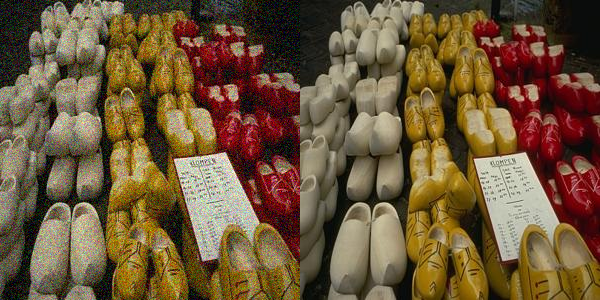

In [ ]:
number = 32

print ( '1. Gaussian noise with sigma= 25       2.The Original Image')
numpy_horizontal = np.hstack((purenoise[number], orgimages[number]))
cv2_imshow(numpy_horizontal)

In [ ]:
#Loading tapered images
imgDir = %pwd
trainDir = os.path.join(imgDir, 'tapered test')
# trainrefDir = os.path.join(imgDir, 'test truth for tapered test')
print (trainDir)

t_taped_ref, tgnoisy10, tgnoisy1, tmotion, tdisk = LoadData(trainDir, 'D')
# t_taped_ref, tgnoisy10, tgnoisy1, tmotion, tdisk = LoadData(trainrefDir, 'C')
t_taped_ref = np.array(t_taped_ref)
tgnoisy1 = np.array(tgnoisy1)
tgnoisy10 = np.array(tgnoisy10)
tmotion = np.array(tmotion)
tdisk = np.array(tdisk)

/content/gdrive/My Drive/239 Computational Imaging Project/BSR/BSDS500/data/images/tapered test


1. Gaussian noise with sigma= 25       2.The Original Image                   3.Gaussian blur with sigma= 1          and 4. Gaussian blur sigma= 10.2 


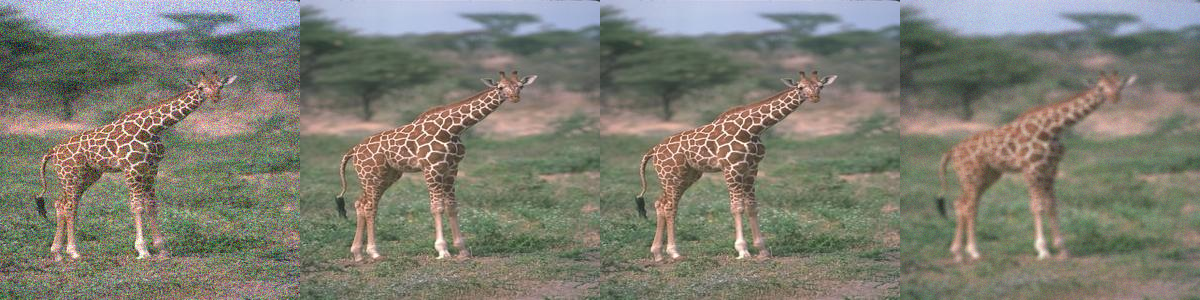

5. Disk Blur                           6.Motion Blur                          7. Tapered Images                      and 2. The Original Images


In [ ]:
number = 32
number_1 = 35

print ( '1. Gaussian noise with sigma= 25       2.The Original Image                   3.Gaussian blur with sigma= 1          and 4. Gaussian blur sigma= 10.2 ') 
numpy_horizontal = np.hstack((tpurenoise[number], torgimages[number]))
numpy_horizontal1 = np.hstack((torgimages[number], tgnoisy10[number]))
numpy_horizontal = np.hstack((numpy_horizontal,numpy_horizontal1))
cv2_imshow(numpy_horizontal)

print ( '5. Disk Blur                           6.Motion Blur                          7. Tapered Images                      and 2. The Original Images') 
# numpy_horizontal = np.hstack((tdisk[number_1], tmotion[number_1]))
# numpy_horizontal1 = np.hstack((t_taped_ref[number_1], torgimages[number_1]))
# numpy_horizontal = np.hstack((numpy_horizontal,numpy_horizontal1))
# cv2_imshow(numpy_horizontal)

#Undestanding the debluring process

In [ ]:
def blur_filter(img, kernel):
    # kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = [row,col])
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def deblur_filter(img, kernel, alpha):
    kernel /= np.sum(kernel)
    t_kernel = np.transpose(kernel)
    
    dummy = alpha*np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = [row,col])
    t_kernel = np.fft.fft2(t_kernel, s = [row,col])
    dummy = dummy / ( np.abs(kernel)**2 *alpha+ 3)
    dummy = np.real(np.fft.ifft2(dummy))
    return dummy    

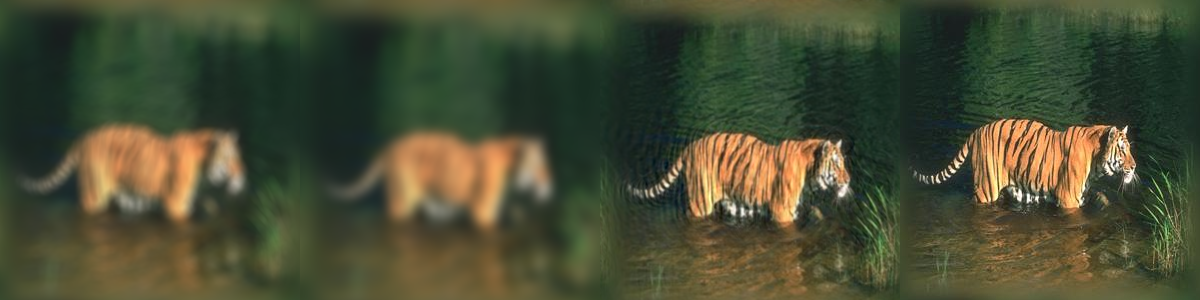

In [ ]:
kerneltype = disk_kernel
alpha = 5000 #different alpha will result in different deblured image
idd = 10
original = taped_ref[idd]

result = np.zeros(original.shape, dtype=np.float32)
for i in range(original.shape[2]):
  result[:,:,i] = blur_filter(taped_ref[idd][:,:,i], (kerneltype))

result1 = np.zeros(original.shape, dtype=np.float32)
for i in range(original.shape[2]):
  result1[:,:,i] = blur_filter(result[:,:,i], (np.transpose(kerneltype)))

result2 = np.zeros(original.shape, dtype=np.float32)
for i in range(original.shape[2]):
  result2[:,:,i] = deblur_filter(result1[:,:,i], kerneltype, alpha)

h = np.hstack((result, result1))
h1 = np.hstack((result2, taped_ref[idd])) 
h = np.hstack((h, h1))
cv2_imshow(h)

#New Helper Functions

## Unrolled Part

### CNN/CNN Prior

1. We used a **single residual connection** between input and output ( x_k+1/2 = x_k + φ(x_k), where φ is an n-layer convolutional network with batch normalization and ReLu nonlinearities. )
1. The **first convolutional layer had 1 or 3 input channels** (depending on whether the images were grayscale or color) and d output channels. 
1. The **n − 2 intermediate** convolutional layers had **d input** channels and **d output** channels. 
1. The **final** convolutional layer had **d input** channels and **1 or 3 output channels** (again depending on the number of channels in the image). 
1. We used **d = 64 for all experiments** and **3 × 3 kernels**

In [ ]:
def add_common_layers(y):
  y = layers.core.Activation('relu')(y) #add ReLu
  return y

#CNN layers
def cnn_prior(inx,num_iter = 4, nb_channels_in = 32, kernel_size = 3):

  x = Lambda(lambda inx: tf.identity(inx))(inx)
  x = Lambda(lambda x: tf.cast(x,tf.float32))(x)

  #the first conv layer
  cnnx = layers.Conv2D(3, kernel_size=kernel_size, strides=(1, 1), padding='same')(x)
  cnnx = add_common_layers(cnnx)

  #the n-2 intermediate conv layers
  for i in range(num_iter):
    cnnx = layers.Conv2D(nb_channels_in, kernel_size=kernel_size, strides=(1, 1), padding='same')(cnnx)
    cnnx = add_common_layers(cnnx) 
  
  #the last conv layer
  cnnx = layers.Conv2D(3, kernel_size=kernel_size, strides=(1, 1), padding='same')(cnnx)

  return cnnx

### deminator/numerator/convert tensor

* X_K+1 = F^-1{F{x+CNN(X)+1/2conv(k',y)}/(1/2|K|^2+1)}
* k = kernel (blur, constant 1 for denoise, IFFT(P) for CSMRI)
* x = x_i, i.e. input for current iteration; y = observed image
* dummy variable, cnnx = cnn output for x
* for first iteration, x_1 is initialized as conv(k',y)

Calculating kT * y

In [ ]:
def make_denominator(resizekernel):
  output =  (tf.abs(resizekernel))**2*thealpha + 1
  return output

def make_numerator(x,cnnx, ky):
  output =  tf.cast(x,tf.float32) + tf.cast(cnnx,tf.float32) + thealpha*(ky)
  return output

def divide_values(numerator, denominator):
  return numerator/denominator

In [ ]:
def conv_tensors(y): #calculating k^T*y
  transp = np.transpose(kernaltype)
  kernel_transpose = tf.convert_to_tensor(transp)
  kernel_transpose = tf.expand_dims(kernel_transpose, -1)
  kernel_transpose = tf.expand_dims(kernel_transpose, -1)
  kernel_transpose = tf.tile(kernel_transpose,[1,1,3,1]) #3,3,3,1
  point_filter = tf.eye(3,batch_shape = [1,1])
  image_array = tf.nn.separable_conv2d(y, kernel_transpose, point_filter, strides = [1,1,1,1],padding = 'SAME')
  return image_array  

def generate_resize(y): #resize the kernal w/ FT

  k = np.fft.fft2(kernaltype, s = [row,col])

  result = np.zeros([row,col,ch], dtype=np.float32)
  result[:,:] = k[:,:,np.newaxis]
  kernel = tf.convert_to_tensor(result)

  return kernel

###Fourier Transform

In [ ]:
def fourier_transform(img):
  output_list = []
  dummy = tf.identity(img)

  for i in range(dummy.shape[3]):
    the_output = tf.fft2d(dummy[:,:,:,i])
    output_list.append(the_output)

  output = tf.stack(output_list, axis=3)
  return output


def inverse_fourier_transform(img):
  output_list = []
  dummy = tf.identity(img)

  for i in range(dummy.shape[3]):
    output_list.append(tf.abs(tf.ifft2d(dummy[:,:,:,i])))
  
  output = tf.stack(output_list, axis=3)
  return output

## Proximal Gradient
* cnn(x) will be 4d tensor: expand kernel to 4d
* x should be 4d tensor as well, only concern is that when initializing conv(k',y) as x_1,, you expand it to 4d first

In [ ]:
def proximal_grad(x,cnnx, y, resizekernel):
  
  ky = Lambda(lambda x: conv_tensors(x))(y) # calculate k^T*y

  ifftnumerator = Lambda(lambda x: make_numerator(x[0], x[1], x[2]))([x,cnnx,ky]) # cnnx + x + alpha*(k^T*y)
  ifftnumerator = Lambda(lambda ifftnumerator: tf.cast(ifftnumerator,tf.complex128))(ifftnumerator) #chane numerator type to complex128
  
  numerator = Lambda(lambda ifftnumerator: fourier_transform(ifftnumerator))(ifftnumerator) #fourier transform
  numerator = Lambda(lambda numerator: tf.cast(numerator,tf.complex128))(numerator) #chane numerator type to complex128

  resizekernel = Lambda(lambda resizekernel: tf.cast(resizekernel, tf.complex128))(resizekernel) #change the kernal type to complex128
  denominator = Lambda(lambda x: make_denominator(x))(resizekernel)
  
  denominator = Lambda(lambda denominator: tf.cast(denominator,tf.complex128))(denominator) #change type
  denominator = Lambda(lambda denominator: tf.expand_dims(denominator,0))(denominator) #expand dimension

  fftoutput = Lambda(lambda x: divide_values(x[0],x[1]))([numerator,denominator]) # times the denominator
  output = Lambda(lambda fftoutput: inverse_fourier_transform(fftoutput))(fftoutput) #inverse fourier transform
  # output = Lambda(lambda ifftoutput: tf.real(ifftoutput))(ifftoutput) #only the aboslute value
  
  return output

##Full OPD Network

In [ ]:
# Loss function for examing results
def myoldPSNR(y_true, y_pred):
  max_pixel = 255.0
  mse = (np.mean(np.square(y_pred - y_true)))
  output =  (10.0 * np.log10((max_pixel ** 2) /mse))
  return output

In [ ]:
# LOSS FUNCTION for Model
def myPSNR(y_true, y_pred):
  psnr =  tf.image.psnr(tf.cast(y_pred,tf.float32),tf.cast(y_true,tf.float32), max_val = 255.0)
  mseloss = tf.keras.losses.MSE(tf.cast(y_true,tf.float32), tf.cast(y_pred,tf.float32))
  l2norm =  tf.norm((tf.cast(y_pred,tf.float32) - tf.cast(y_true,tf.float32)))**2/(2*5.7020)
  return -1*psnr

In [ ]:
def ODP(y, iterations):
  resizekernel = Lambda(lambda x: generate_resize(x))(y) #resize the kernal to 4dd
  x0 = Lambda(lambda x: conv_tensors(x))(y) #calculate the inital x0 (k^T*y)
  
  for i in range(iterations): #number of iterations
    cnnx1 = cnn_prior(x0) #calculating cnnx
    thealpha = C0 * 2**(-i) #initalize alpha_i
    x0 = Lambda(lambda myInput: proximal_grad(myInput[0], myInput[1], myInput[2], myInput[3]))([x0, cnnx1, y, resizekernel])

  return x0

#Pure CNN Models

In [ ]:
def cnn_only(y):
  cnnx1 = cnn_prior(y)
  return cnnx1

In [ ]:
rgb = 3
image_tensor = layers.Input(shape=(row,col,rgb))
network_output = cnn_only(image_tensor)
  
cnnonly = models.Model(inputs=[image_tensor], outputs=[network_output])                                                 
#print(cnnonly.summary())


1.Motion Blur

In [ ]:
#cnn only, motion blur kernel
cnnonly.compile(optimizer = 'adam', loss=myPSNR, metrics=['mean_squared_error'])
odpmodel = cnnonly.fit(gmotion,orgimages, epochs = 70,batch_size = 4).history

2.Disk Blur

In [ ]:
#cnn only, disk kernel
cnnonly.compile(optimizer = 'adam', loss=myPSNR, metrics=['mean_squared_error'])
odpmodel = cnnonly.fit(gdisk,orgimages, epochs = 70,batch_size = 4).history

CNN Testing Result

In [ ]:
index = 100
a = purenoise[index][np.newaxis, :]
a.shape
res = model.predict_on_batch(a)

In [ ]:
#cnn only disk RESULTS
res = cnnonly.predict(tdisk)
index = 7
cv2_imshow(torgimages[index])
cv2_imshow(res[index])

cv2_imshow(tdisk[index])


psnr = myoldPSNR(orgimages[index],res[0])
print('The PSNR after denoising', 'picture', index, '= ', psnr)
oldpsnr = myoldPSNR(orgimages[index], purenoise[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '                   The model-predicted picture', index, '          The purenoise picture', index )
numpy_horizontal1 = np.hstack((orgimages[index], res[0]))
numpy_horizontal = np.hstack((numpy_horizontal1,purenoise[index]))
cv2_imshow(numpy_horizontal)

In [ ]:
#cnn only, motion blur kernel


#New Models

###**(A)Denoising**

**Denoising on noise level σ = 25 and test set from [7]**

1. We trained an ODP proximal gradient network for denoising with **4 iterations and a 10 layer, 64 channel residual CNN prior with ReLu 
nonlinearities.** 
1. We trained on the **400** image test set from [7], with **data augmentation** via flipping, rotation by 90 degrees, and dynamic noise generation. 
1. We used **Xavier initialization [3] for the CNN** and parameterized **αk as αk = C_0 x C_k with C0 and Ck learnable, initialized to C_0 = 0 and C_k = 2^−k.** 
1. We used a **mean-squared-error loss**. 
1. We used a **validation set of 500 images** from the ImageNet validation set [2]. 
1. We **scaled the input images** from [ 0, 255 ] and **cropped them to 180 x 180**. 
1. We used **Adam [4] with a learning rate of 0.001 decayed exponentially by factor 0.5 every 300 epochs**. 
1. We used **Adam β1 = 0.9, Adam β2 = 0.999, and weight decay 0.0001.** 
1. We **tested the model trained for 134, 068 iterations with batch size 4** on a Titan X GPU, chosen through evaluation on the validation set.


This model will have different weights for the CNN for each iteration, but this is OK, there are 2 versions of the model (1 with weights same over iterations, 1 with different weights per iter, the results aren't very different)


In [ ]:
kernaltype = identity_kernel
thealpha = 0.0 
C0 = 0.0
rgb = 3
iteration = 4
image_tensor = layers.Input(shape=(row,col,rgb))

network_output = ODP(image_tensor, iteration)
model = models.Model(inputs=[image_tensor], outputs=[network_output])                                                  
# print(model.summary())
model.compile(optimizer='adam', loss=myPSNR, metrics=['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)
(1, 300, 300, 3)


In [ ]:
odpmodel = model.fit( purenoise, orgimages, epochs = 7, batch_size = 4).history

Epoch 1/7
200/200 [==============================] - 31s 156ms/step - loss: -22.1335 - mean_squared_error: 956.9381
Epoch 2/7
200/200 [==============================] - 18s 92ms/step - loss: -27.6479 - mean_squared_error: 116.9812
Epoch 3/7
200/200 [==============================] - 18s 92ms/step - loss: -28.8373 - mean_squared_error: 89.9788
Epoch 4/7
200/200 [==============================] - 18s 92ms/step - loss: -28.9574 - mean_squared_error: 87.6814
Epoch 5/7
200/200 [==============================] - 18s 92ms/step - loss: -29.4824 - mean_squared_error: 78.5877
Epoch 6/7
200/200 [==============================] - 18s 92ms/step - loss: -29.6150 - mean_squared_error: 76.1097
Epoch 7/7
200/200 [==============================] - 18s 92ms/step - loss: -29.8433 - mean_squared_error: 72.6802


The PSNR after denoising picture 100 =  30.57383730022751
The original PSNR of picture 100 =  20.176829316390318
-------------------------------------------------------------------------------------
The original picture 100                    The model-predicted picture 100           The purenoise picture 100


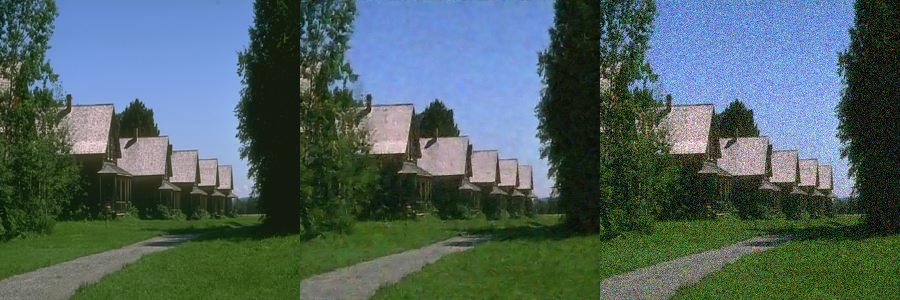

In [ ]:
index = 100
a = purenoise[index][np.newaxis, :]
a.shape
res = model.predict_on_batch(a)
#DENOISE RESULTS
psnr = myoldPSNR(orgimages[index],res[0])
print('The PSNR after denoising', 'picture', index, '= ', psnr)
oldpsnr = myoldPSNR(orgimages[index], purenoise[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '                   The model-predicted picture', index, '          The purenoise picture', index )
numpy_horizontal1 = np.hstack((orgimages[index], res[0]))
numpy_horizontal = np.hstack((numpy_horizontal1,purenoise[index]))
cv2_imshow(numpy_horizontal)

In [ ]:
index = 100
a = purenoise[index][np.newaxis, :]
a.shape
res = model.predict_on_batch(a)

The PSNR after denoising picture 100 =  30.201152854398657
The original PSNR of picture 100 =  20.18538112219248
-------------------------------------------------------------------------------------
The original picture 100                    The model-predicted picture 100           The purenoise picture 100


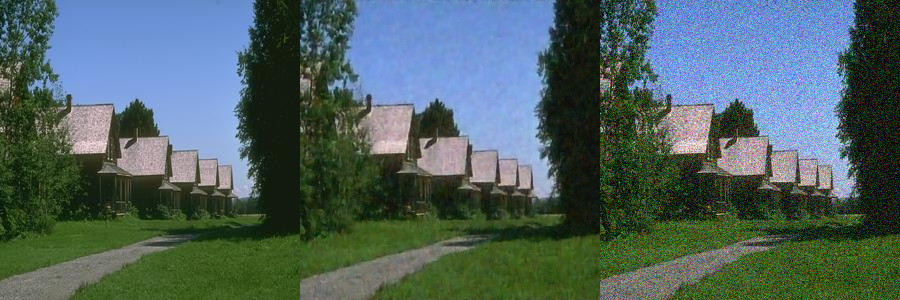

In [ ]:
#DENOISE RESULTS
psnr = myoldPSNR(orgimages[index],res[0])
print('The PSNR after denoising', 'picture', index, '= ', psnr)
oldpsnr = myoldPSNR(orgimages[index], purenoise[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '                   The model-predicted picture', index, '          The purenoise picture', index )
numpy_horizontal1 = np.hstack((orgimages[index], res[0]))
numpy_horizontal = np.hstack((numpy_horizontal1,purenoise[index]))
cv2_imshow(numpy_horizontal)

#### Testing Results

In [ ]:
test_res = model.predict(tpurenoise)

NameError: ignored

In [ ]:
#DEBLUR RESULTS
avgpsnr = 0
refpsnr = 0
for i in range(200):
  avgpsnr = avgpsnr + myoldPSNR(torgimages[i],test_res[i])/200
  refpsnr = refpsnr + myoldPSNR(torgimages[i],tpurenoise[i])/200

print('The model average psnr = ', avgpsnr)
print('The original agerage psnr = ', refpsnr)
print ( '---------------------------------')

index = 188
psnr, oldpsnr = 0, 0

psnr = myoldPSNR(torgimages[index],test_res[index])
print('The model psnr for picture', index, ' = ', psnr)
oldpsnr = myoldPSNR(torgimages[index],tpurenoise[index])
print('The original psnr for picture', index, ' = ', oldpsnr)

print('The original picture', index, '                   The model-predicted picture', index, '          The purenoise picture', index )
numpy_horizontal = np.hstack((torgimages[index], test_res[index]))
numpy_horizontal = np.hstack((numpy_horizontal,tpurenoise[index]))
cv2_imshow(numpy_horizontal)


NameError: ignored

###**(B)Debluring**

**Deblurring using image formation and test set from [8]**

1. We trained an ODP proximal gradient network for deblurring with **8 iterations and a 5 layer, 64 channel residual CNN prior with ReLu nonlinearities.** 
1. We trained one model for the **disk blur kernel** and another model for the motion **blur kernel** on the 1.2e6 ImageNet training images [2], with **data augmentation** via flipping, rotation by 90 degrees, and **dynamic noise generation at σ = 5.7020.**
1. We used **Xavier initialization [3] for the CNN** and parameterized **αk as αk = C0Ck with C0 and Ck learnable, initialized to C0 = 1000 and Ck = 2−k.** 
1. We used a **mean-squared-error loss.** Xu et al. also train one model per kernel [8]. 
1. We used a **validation set of 500 images** from the ImageNet validation set [2]. 
1. We scaled the input images from [0, 255] and **cropped them to 256 × 256,** with **replication padding equal to 1/2 the kernel size**. Xu et al. used the same padding scheme [8]. 
1. We used **Adam [4] with a learning rate of 0.01 decayed exponentially by factor 0.5 every 0.25 epochs. We used Adam β1 = 0.9, Adam β2 = 0.999**, and **weight decay 0.0001**. 
1. We tested the disk blur model trained for 149, 820 iterations with batch size 4 on a Titan X GPU, chosen through evaluation on the validation set. 
1. We tested the disk blur model trained for 151, 736 iterations with batch size 4 on a Titan X GPU, chosen through evaluation on the validation set.


#### 1.Blur with sigma = 10.2

In [ ]:
kernaltype = gaussian_kernel_sigma10_2
thealpha = 0.0 
C0 = 1000
rgb = 3
iteration = 7
image_tensor = layers.Input(shape=(row,col,rgb))

network_output = ODP(image_tensor, iteration)
model = models.Model(inputs=[image_tensor], outputs=[network_output])                                                  
#print(model.summary())
model.compile(optimizer = 'adam', loss=myPSNR, metrics=['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
odpmodel_blur10 = model.fit(gnoisy10, taped_ref, epochs = 15, batch_size = 4).history

Epoch 1/15
200/200 [==============================] - 51s 253ms/step - loss: -22.3267 - mean_squared_error: 5507.6174
Epoch 2/15
200/200 [==============================] - 32s 160ms/step - loss: -25.9024 - mean_squared_error: 215.1240
Epoch 3/15
200/200 [==============================] - 32s 160ms/step - loss: -27.0667 - mean_squared_error: 161.8746
Epoch 4/15
200/200 [==============================] - 32s 160ms/step - loss: -27.4763 - mean_squared_error: 147.4999
Epoch 5/15
200/200 [==============================] - 32s 160ms/step - loss: -27.6265 - mean_squared_error: 142.8382
Epoch 6/15
200/200 [==============================] - 32s 160ms/step - loss: -27.7473 - mean_squared_error: 139.1109
Epoch 7/15
200/200 [==============================] - 32s 160ms/step - loss: -27.9274 - mean_squared_error: 133.7079
Epoch 8/15
200/200 [==============================] - 32s 160ms/step - loss: -27.9639 - mean_squared_error: 132.6056
Epoch 9/15
  4/200 [..............................] - ETA: 31s 

KeyboardInterrupt: ignored

In [ ]:
index = 100
b = gnoisy10[index][np.newaxis, :]
b.shape
res10 = model.predict_on_batch(b)

The PSNR after denoising picture 100 =  29.017809325631198
The original PSNR of picture 100 =  25.548646744972476
-------------------------------------------------------------------------------------
The original picture 100               The model-predicted picture 100        The gaussian blur = 10.2 picture 100


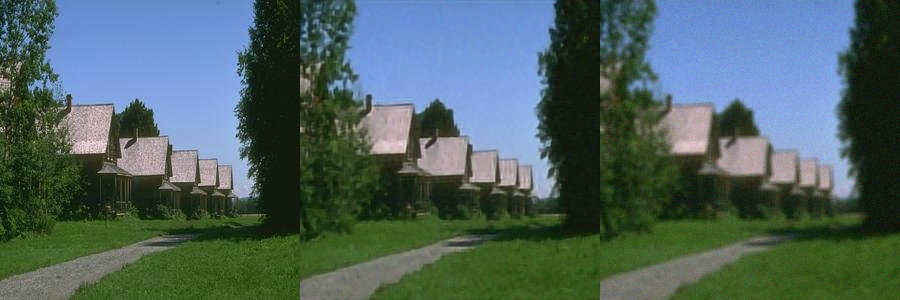

In [ ]:
#DEBLUR RESULTS

psnr = myoldPSNR(taped_ref[index],res10[0])
print('The PSNR after denoising', 'picture', index, '= ', psnr)
oldpsnr = myoldPSNR(taped_ref[index], gnoisy10[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '              The model-predicted picture', index, '       The gaussian blur = 10.2 picture', index )
numpy_horizontal1 = np.hstack((orgimages[index], res10[0]))
numpy_horizontal = np.hstack((numpy_horizontal1,gnoisy10[index]))
cv2_imshow(numpy_horizontal)

Testing results

In [ ]:
test_res10 = model.predict(tgnoisy10)

The model average psnr =  27.63221437969876
The original agerage psnr =  24.07505334279423
---------------------------------
The model psnr for picture 190  =  29.874209995650496
The original psnr for picture 100  =  25.5611976724117
The original picture 190               The original Image 190                  The model-deblured picture 190         The gaussian blur = 10.2 picture 190


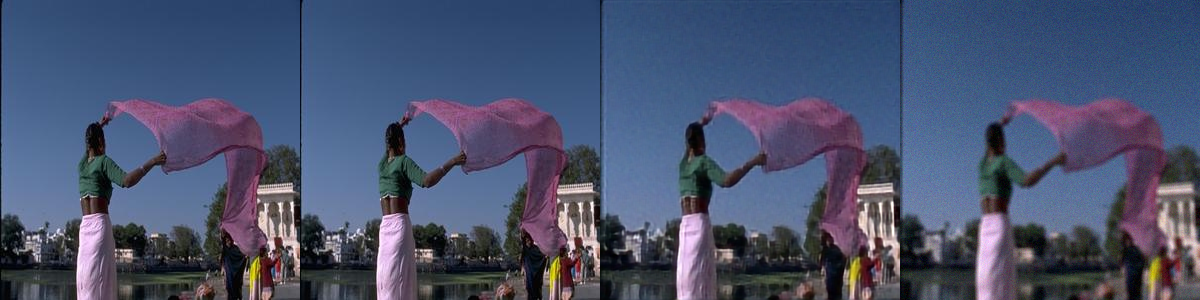

In [ ]:
#DEBLUR RESULTS
avgpsnr = 0
refpsnr = 0
datasize = orgimages.shape[0]
for i in range(datasize):
  avgpsnr = avgpsnr + myoldPSNR(t_taped_ref[i],test_res10[i])/datasize
  refpsnr = refpsnr + myoldPSNR(t_taped_ref[i],tgnoisy10[i])/datasize

print('The model average psnr = ', avgpsnr)
print('The original agerage psnr = ', refpsnr)
print ( '---------------------------------')

index10 = 190
psnr, oldpsnr = 0, 0

psnr = myoldPSNR(t_taped_ref[index10],test_res10[index10])
print('The model psnr for picture', index10, ' = ', psnr)
oldpsnr = myoldPSNR(t_taped_ref[index10],tgnoisy10[index10])
print('The original psnr for picture', index, ' = ', oldpsnr)

print('The original picture', index10, '              The original Image', index10, '                 The model-deblured picture', index10, '        The gaussian blur = 10.2 picture', index10  )
numpy_horizontal1 = np.hstack((torgimages[index10], t_taped_ref[index10]))
numpy_horizontal = np.hstack((test_res10[index10],tgnoisy10[index10]))
numpy_horizontal = np.hstack((numpy_horizontal1,numpy_horizontal))
cv2_imshow(numpy_horizontal)


#### 2.Blur with simga = 1

In [ ]:
kernaltype = gaussian_kernel_sigma1
thealpha = 0.0 
C0 = 1000
rgb = 3
iteration = 7
image_tensor = layers.Input(shape=(row,col,rgb))

network_output = ODP(image_tensor, iteration)
model = models.Model(inputs=[image_tensor], outputs=[network_output])                                                  
#print(model.summary())
model.compile(optimizer = 'adam', loss=myPSNR, metrics=['mean_squared_error'])

In [ ]:
odpmodel_blur1 = model.fit(gnoisy1, taped_ref, epochs = 9 ,batch_size = 4).history

Epoch 1/9
600/600 [==============================] - 54s 91ms/step - loss: -28.4970 - mean_squared_error: 231.4924
Epoch 2/9
600/600 [==============================] - 37s 62ms/step - loss: -30.8066 - mean_squared_error: 65.8425
Epoch 3/9
600/600 [==============================] - 37s 62ms/step - loss: -31.1359 - mean_squared_error: 61.3954
Epoch 4/9
600/600 [==============================] - 37s 62ms/step - loss: -31.2284 - mean_squared_error: 60.1376
Epoch 5/9
600/600 [==============================] - 37s 62ms/step - loss: -31.3866 - mean_squared_error: 58.2745
Epoch 6/9
600/600 [==============================] - 37s 62ms/step - loss: -31.4418 - mean_squared_error: 57.6542
Epoch 7/9
600/600 [==============================] - 37s 62ms/step - loss: -31.5294 - mean_squared_error: 56.6280
Epoch 8/9
600/600 [==============================] - 37s 62ms/step - loss: -31.5720 - mean_squared_error: 56.0823
Epoch 9/9
600/600 [==============================] - 37s 62ms/step - loss: -31.5937 - m

In [ ]:
index = 102
c = gnoisy1[index][np.newaxis, :]
c.shape
test_res1 = model.predict_on_batch(c)

The PSNR after denoising picture 102 =  38.96974676850003
The original PSNR of picture 102 =  30.48539076784117
-------------------------------------------------------------------------------------
The original picture 102                The model-deblured picture 102           The gaussian noise = 1 102           The tapered Image 102


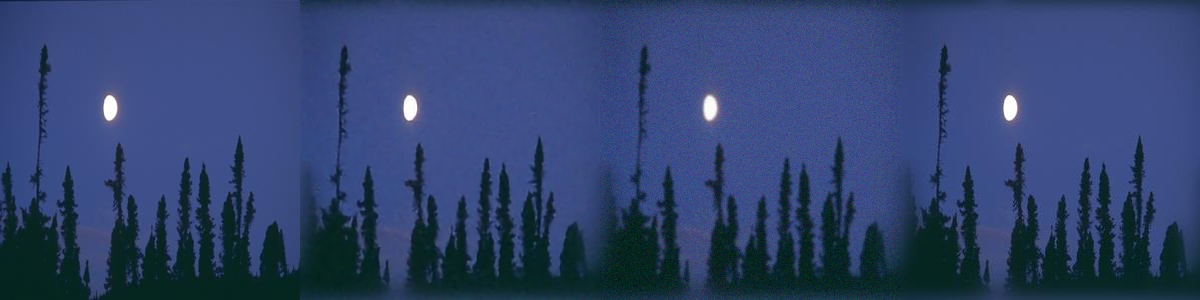

In [ ]:
#DEBLUR RESULTS

psnr = myoldPSNR(taped_ref[index],test_res1[0])
print('The PSNR after denoising', 'picture', index, '= ', psnr)
oldpsnr = myoldPSNR(taped_ref[index], gnoisy1[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '               The model-deblured picture', index, '          The gaussian noise = 1  ', '           The tapered Image', index  )
numpy_horizontal1 = np.hstack((orgimages[index], test_res1[0]))
numpy_horizontal = np.hstack((gnoisy1[index],taped_ref[index]))
numpy_horizontal = np.hstack((numpy_horizontal1,numpy_horizontal))
cv2_imshow(numpy_horizontal)

Testing results

In [ ]:
test_res1 = model.predict(tgnoisy1)

The model average psnr =  31.257202150472157
The original agerage psnr =  26.836610097664927
---------------------------------
The model psnr for picture 188  =  26.92625514148841
The original psnr for picture 188  =  23.49861461329009
The original picture 188               The tapered Image 188                  The model-deblured picture 188         The gaussian noise = 10.2 picture 188


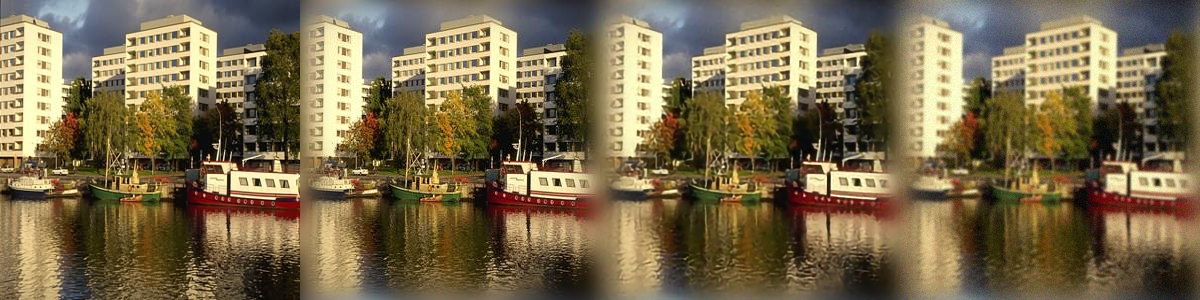

In [ ]:
#DEBLUR RESULTS
avgpsnr = 0
refpsnr = 0
for i in range(200):
  avgpsnr = avgpsnr + myoldPSNR(t_taped_ref[i],test_res1[i])/200
  refpsnr = refpsnr + myoldPSNR(t_taped_ref[i],tgnoisy1[i])/200

print('The model average psnr = ', avgpsnr)
print('The original agerage psnr = ', refpsnr)
print ( '---------------------------------')

index1 = 188
psnr, oldpsnr = 0, 0

psnr = myoldPSNR(t_taped_ref[index1],test_res1[index1])
print('The model psnr for picture', index1, ' = ', psnr)
oldpsnr = myoldPSNR(t_taped_ref[index1],tgnoisy1[index1])
print('The original psnr for picture', index1, ' = ', oldpsnr)

print('The original picture', index1, '              The tapered Image', index1, '                 The model-deblured picture', index1, '        The gaussian noise = 10.2 picture', index1  )
numpy_horizontal1 = np.hstack((torgimages[index1], t_taped_ref[index1]))
numpy_horizontal = np.hstack((test_res1[index1],tgnoisy1[index1]))
numpy_horizontal = np.hstack((numpy_horizontal1,numpy_horizontal))
cv2_imshow(numpy_horizontal)

#### 3.Motion blur

In [ ]:
kernaltype = motion_kernel
thealpha = 0.0 
C0 = 1000
rgb = 3
iteration = 8
image_tensor = layers.Input(shape=(row,col,rgb))

network_output = ODP(image_tensor, iteration)
model = models.Model(inputs=[image_tensor], outputs=[network_output])                                                  
# print(model.summary())
model.compile(optimizer = 'adam', loss=myPSNR, metrics=['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [ ]:
odpmodel_motionblur = model.fit(motion, taped_ref, epochs = 23, batch_size = 4).history

Epoch 1/23
600/600 [==============================] - 53s 88ms/step - loss: -20.5222 - mean_squared_error: 700.9762
Epoch 2/23
172/600 [=======>......................] - ETA: 29s - loss: -20.8303 - mean_squared_error: 651.8350

KeyboardInterrupt: ignored

In [ ]:
 index = 52
b = motion[index][np.newaxis, :]
b.shape
motionres = model.predict_on_batch(b)

The PSNR after motion debluring picture 52 =  24.523666759453704
The original PSNR of picture 52 =  22.056714514571418
-------------------------------------------------------------------------------------
The original picture 52               The model-predicted picture 52        The gaussian noise = 10.2 picture 52


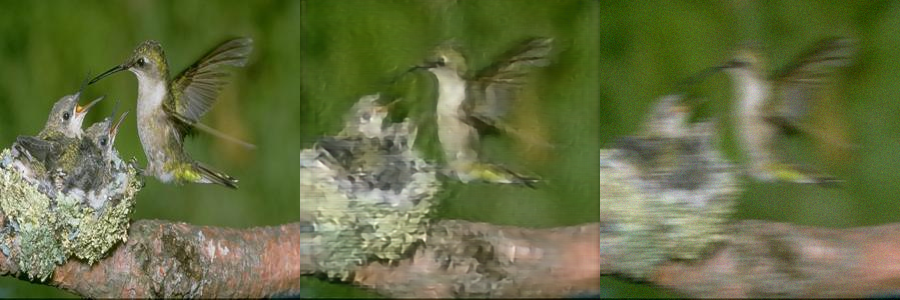

In [ ]:
#MOTION DEBLUR RESULTS

psnr = myoldPSNR(taped_ref[index],motionres[0])
print('The PSNR after motion debluring picture', index, '= ', psnr)
oldpsnr = myoldPSNR(taped_ref[index], motion[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '              The model-predicted picture', index, '       The gaussian noise = 10.2 picture', index )
numpy_horizontal1 = np.hstack((orgimages[index], motionres[0]))
numpy_horizontal = np.hstack((numpy_horizontal1, motion[index]))
cv2_imshow(numpy_horizontal)

In [ ]:
test_resmotion = model.predict(tmotion)

The model average psnr =  24.102135790011072
The original agerage psnr =  21.42706056917282
---------------------------------
The model psnr for picture 7  =  21.713690968748693
The original psnr for picture 59  =  18.983432873246453
The original picture 7                    The model-deblured picture 7           The gaussian noise = 10.2 picture 7


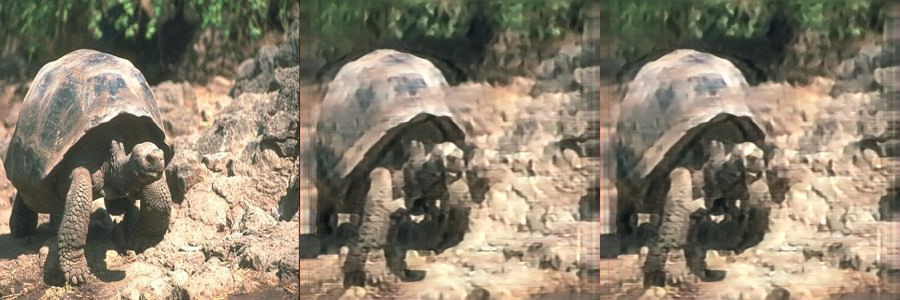

In [ ]:
#DEBLUR RESULTS
avgpsnr = 0
refpsnr = 0
datasize = orgimages.shape[0]
for i in range(datasize):
  avgpsnr = avgpsnr + myoldPSNR(t_taped_ref[i],test_resmotion[i])/datasize
  refpsnr = refpsnr + myoldPSNR(t_taped_ref[i],tmotion[i])/datasize

print('The model average psnr = ', avgpsnr)
print('The original agerage psnr = ', refpsnr)
print ( '---------------------------------')

index10 = 7
psnr, oldpsnr = 0, 0

psnr = myoldPSNR(t_taped_ref[index10],test_resmotion[index10])
print('The model psnr for picture', index10, ' = ', psnr)
oldpsnr = myoldPSNR(t_taped_ref[index10],tmotion[index10])
print('The original psnr for picture', index, ' = ', oldpsnr)

print('The original picture', index10, '                   The model-deblured picture', index10, '          The gaussian noise = 10.2 picture', index10 )
numpy_horizontal = np.hstack((torgimages[index10], test_resmotion[index10]))
numpy_horizontal = np.hstack((numpy_horizontal,test_resmotion[index10]))
cv2_imshow(numpy_horizontal)


#### 4.Disk Blur

In [ ]:
kernaltype = disk_kernel
thealpha = 0.0 
C0 = 1000
rgb = 3
iteration = 8
image_tensor = layers.Input(shape=(row,col,rgb))

network_output = ODP(image_tensor, iteration)
model = models.Model(inputs=[image_tensor], outputs=[network_output])                                                  
# print(model.summary())
model.compile(optimizer = 'adam', loss=myPSNR, metrics=['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [ ]:
odpmodel_diskblur = model.fit(disk, taped_ref, epochs = 25, batch_size = 4).history

Epoch 1/25
300/300 [==============================] - 36s 120ms/step - loss: -22.1109 - mean_squared_error: 503.8955
Epoch 2/25
300/300 [==============================] - 23s 77ms/step - loss: -23.0683 - mean_squared_error: 388.9349
Epoch 3/25
300/300 [==============================] - 23s 77ms/step - loss: -23.2546 - mean_squared_error: 371.6801
Epoch 4/25
300/300 [==============================] - 23s 76ms/step - loss: -23.5736 - mean_squared_error: 346.5555
Epoch 5/25
300/300 [==============================] - 23s 76ms/step - loss: -23.7939 - mean_squared_error: 328.4356
Epoch 6/25
300/300 [==============================] - 23s 76ms/step - loss: -24.2779 - mean_squared_error: 293.6176
Epoch 7/25
300/300 [==============================] - 23s 76ms/step - loss: -24.3371 - mean_squared_error: 287.8938
Epoch 8/25
300/300 [==============================] - 23s 76ms/step - loss: -24.5704 - mean_squared_error: 273.7694
Epoch 9/25
300/300 [==============================] - 23s 76ms/step - l

KeyboardInterrupt: ignored

In [ ]:
index = 80
b = disk[index][np.newaxis, :]
b.shape
diskres = model.predict_on_batch(b)

In [ ]:
#DISK DEBLUR RESULTS
psnr = myoldPSNR(taped_ref[index],diskres[0])
print('The PSNR after motion debluring picture', index, '= ', psnr)
oldpsnr = myoldPSNR(taped_ref[index], disk[index])
print('The original PSNR of picture', index, '= ', oldpsnr)
print('-------------------------------------------------------------------------------------')
print ('The original picture', index, '               The model-deblured picture', index, '          The disk blur = ', index, '                  The tapered Image', index  )
numpy_horizontal1 = np.hstack((orgimages[index], diskres[0]))
numpy_horizontal = np.hstack((disk[index],taped_ref[index]))
numpy_horizontal = np.hstack((numpy_horizontal1,numpy_horizontal))
cv2_imshow(numpy_horizontal)

Disk Blur Testing Resuls

In [ ]:
test_resdisk = model.predict(tdisk)

The model average psnr =  24.912760781828503
The original agerage psnr =  22.259249149865617
---------------------------------
The model psnr for picture 22  =  31.359439981456983
The original psnr for picture 22  =  27.49825490222762
The original picture 22               The model-deblured picture 22        The tapered picture 22                 The disk blur picture 22


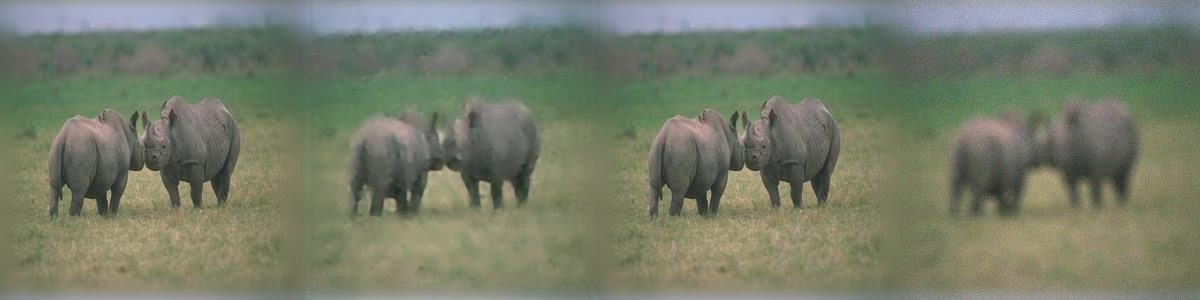

In [ ]:
#DISK DEBLUR RESULTS

avgpsnr = 0
refpsnr = 0
datasize = orgimages.shape[0]
for i in range(datasize):
  avgpsnr = avgpsnr + myoldPSNR(t_taped_ref[i],test_resdisk[i])/datasize
  refpsnr = refpsnr + myoldPSNR(t_taped_ref[i],tdisk[i])/datasize

print('The model average psnr = ', avgpsnr)
print('The original agerage psnr = ', refpsnr)
print ( '---------------------------------')

index10d = 22
psnr, oldpsnr = 0, 0

psnr = myoldPSNR(t_taped_ref[index10d],test_resdisk[index10d])
print('The model psnr for picture', index10d, ' = ', psnr)
oldpsnr = myoldPSNR(t_taped_ref[index10d],tdisk[index10d])
print('The original psnr for picture', index10d, ' = ', oldpsnr)

print('The original picture', index10d, '              The model-deblured picture', index10d, '       The tapered picture', index10d, '                The disk blur picture', index10d  )
numpy_horizontal1 = np.hstack((t_taped_ref[index10d], test_resdisk[index10d]))
numpy_horizontal = np.hstack((t_taped_ref[index10d], tdisk[index10d]))
numpy_horizontal = np.hstack((numpy_horizontal1,numpy_horizontal))
cv2_imshow(numpy_horizontal)
